# System reliability analysis

This notebook contains the code used to evaluate the reliability of the developed system on its two configurations (C1 and C2), where the baseline are the manually computed results from video analysis. This documents includes:

- Information regarding the subjects involved in the evaluation (age, gender)
- Classification of system executions in _success_, _partial_success_, and _failure_.
- Analysis of system errors, i.e., _system_result_ - _manual_result_, for each system configuration and TUG duration and subphases. Statistical comparison of those errors with 0 (i.e., distribution statistically differs from error == 0)
- Computation of intra-subject RMSE and analysis of inter-subject RMSE. Statistical comparison of inter-subject RMSE for durationa and each subphase by system configuration (i.e., which configuration has better RMSE in each subphase).
- Bland-Altman agreement analysis: measurement agreement between each system configuration and manual results.
- Intra-Class Correlation Coefficient: reliability analysis between each system configuration and manual results. Model: **ICC<sub>(2,1)</sub>**

**Inputs:** (`03_EXPERIMENT/01_INPUT/`)

- `s*/s*_sw.json`: JSON file obtained from the system containing the results of configuration C1.
- `s*/s*_sp.json`: JSON file obtained from the system containing the results of configuration C2.
- `s*/s*_results.csv`: CSV file containing the activity boundaries obtained from manual video analysis.
- `subjects.csv`: information regarding subjects.

**Outputs:** (`03_EXPERIMENT/02_OUTPUT/`)

- `01_{man|c1|c2}-results.csv`: duration of each TUG subphase for both system configuration and the manual results. Each TUG execution in the system results is classified as _success_, _partial_success_ or _failure_.
- `02_errors.csv`: _system_result_ - _manual_result_.
- `03_execution-status.csv` (**Table III**): summary of _success_, _partial_success_ and _failure_ executions for each configuration.
- `04_error-distribution.pdf` (**Figure 6**): boxplot with errors distributions by system configuration and subphase. Contains p-value of the statistical tests comparing each distribution with 0. 
- `05_subjects-rmse.csv`: intra-subject RMSE for each system configuration and subphase.
- `05_comparison-rmse.csv` (**Table IV**): intra-subject RMSE statistical comparison for each system configuration and subphase
- `06_{c1|c2}-duration-ba.pdf` (**Figure 7**): Bland-Altman agreement analysis of the total duration of the test between both system configurations and the manual results.
- `07_{c1|c2}-phases-ba.pdf` (**Figure 8**): Bland-Altman agreement analysis of each subphase of the test between both system configurations and the manual results.
- `08_icc-results.csv` (**Table V**): ICC reliability analysis of the total duration and each subphase between both system configurations and the manual results.

## Imports

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'

import math

import numpy as np
import pandas as pd
import pingouin as pg

import plotly.offline as poff
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from functions.dataframe import datetime_from, load_subjects_info
from functions.fs_utils import list_subjects_folders, load_json

from scipy import stats

pg.options['round.column.p-val'] = 3
poff.init_notebook_mode()

## Constants

In [2]:
EXPERIMENT_DIR = '03_EXPERIMENT'

EXPERIMENT_DATA = os.path.join(EXPERIMENT_DIR, '01_INPUT')
SW_RESULTS_FILE = '{0}_sw.json'
SP_RESULTS_FILE = '{0}_sp.json'
MAN_RESULTS_FILE = '{0}_results.csv'

EXPERIMENT_RESULTS = os.path.join(EXPERIMENT_DIR, '02_OUTPUT')
RESULTS_DF = os.path.join(EXPERIMENT_RESULTS, '01_{0}-results.csv')
ERRORS_DF = os.path.join(EXPERIMENT_RESULTS, '02_errors.csv')
EXECUTION_STATUS = os.path.join(EXPERIMENT_RESULTS, '03_execution-status.csv')
ERRORS_DISTRIBUTION = os.path.join(EXPERIMENT_RESULTS, '04_error-distribution.pdf')
RMSE_COMPARISON = os.path.join(EXPERIMENT_RESULTS, '{0}-rmse.csv')
BLAND_RESULT = os.path.join(EXPERIMENT_RESULTS, '{0}-ba.pdf')
ICC_RESULT = os.path.join(EXPERIMENT_RESULTS, '08_icc-results.csv')

PHASES = ['standing_up', 'first_walk', 'first_turn', 'second_walk', 'second_turn', 'sitting_down']
DURATION_AND_PHASES = ['duration'] + PHASES

## Functions

### Data loading

In [3]:
def load_experiment_results(path):
    subjects = list_subjects_folders(path)
    sw_results = []
    sp_results = []
    man_results = []
    
    segments_dfs = []

    for subject in subjects:      
        subject_dir = os.path.join(path, subject)
        sw_results_file = os.path.join(subject_dir, SW_RESULTS_FILE.format(subject))
        sp_results_file = os.path.join(subject_dir, SP_RESULTS_FILE.format(subject))
        man_results_file = os.path.join(subject_dir, MAN_RESULTS_FILE.format(subject))

        sw_results.append(extract_system_results(subject, sw_results_file))
        sp_results.append(extract_system_results(subject, sp_results_file))

        man_results.append(extract_manual_results(subject, man_results_file))
    
    return pd.concat(sw_results, axis=0, ignore_index=True), pd.concat(sp_results, axis=0, ignore_index=True), pd.concat(man_results, axis=0, ignore_index=True)


def extract_system_results(subject, results_file):
    def extract_phases_results(phases_results):
        results = {}
        for phase in PHASES:
            results[phase] = phases_results[phase.upper()]['duration'] if phase.upper() in phases_results else np.nan
        return results
            
    full_results = load_json(results_file)
    results = []
    
    for i, result in enumerate(full_results):
        results.append({
            'subject': subject,
            'duration': result['duration'] if result['duration'] != -1 else np.nan,
            **extract_phases_results(result['activitiesResults'])
        })
        
    return pd.DataFrame(results)


def extract_manual_results(subject, results_file):
    def as_milliseconds(timedelta):
        return int(timedelta.total_seconds() * 1000)
    
    results_df = pd.read_csv(results_file, converters={'phase': lambda x: x.strip()})
    results_df.set_index(['execution', 'phase'], inplace=True)
    results = []
    
    for i, (index, df) in enumerate(results_df.groupby(level=0)):
        stand_start = datetime_from(df.loc[(index, 'stand_start')])
        stand_end = datetime_from(df.loc[(index, 'stand_end')])
        turn1_start = datetime_from(df.loc[(index, 'turn1_start')])
        turn1_end = datetime_from(df.loc[(index, 'turn1_end')])
        turn2_start = datetime_from(df.loc[(index, 'turn2_start')])
        turn2_end = datetime_from(df.loc[(index, 'turn2_end')])
        sit_end = datetime_from(df.loc[(index, 'sit_end')])
        results.append({
            'subject': subject,
            'duration': as_milliseconds(sit_end - stand_start),
            'standing_up': as_milliseconds(stand_end - stand_start),
            'first_walk': as_milliseconds(turn1_start - stand_end),
            'first_turn': as_milliseconds(turn1_end - turn1_start),
            'second_walk': as_milliseconds(turn2_start - turn1_end),
            'second_turn': as_milliseconds(turn2_end - turn2_start),
            'sitting_down': as_milliseconds(sit_end - turn2_end),
        })
        
    return pd.DataFrame(results)      


def invalidate_executions(df, executions):
    for subject_id, invalid_executions in executions.items():
        invalid_executions = np.array(invalid_executions) - 1
        index = df[df.subject == subject_id].index[invalid_executions]
        df.loc[index, 'duration'] = np.nan
    return df

### Errors analysis

In [4]:
def check_status(row):
    if pd.isna(row['duration']):
        print(f'Found failure: {row.name}')
        return 'failure'
    elif any(pd.isna(row)):
        print(f'Found partial success: {row.name}')
        return 'partial_success'
    else:
        return 'success'
    

def compute_errors_by_subject(systems_results, man_results):
    def compute_error(app_result, man_result, phase):
        app_value = app_result[phase]
        if app_value == -1:
            return np.nan
        man_value = man_result[phase]
        return app_value - man_value
        
    dfs = []
    columns = DURATION_AND_PHASES
    for system_id, system_results in systems_results.items():
        
        errors = system_results.copy()
        errors[columns] = (system_results[columns] - man_results[columns])
        errors['system'] = system_id
        dfs.append(errors)
        
    return pd.concat(dfs, ignore_index=True)


def error_distribution(errors_df):
    def pval_formatter(val):
        if val < 0.001:
            return '<.001'
        return f'{val:.3f}'
    
    errors_df_tidy = errors_df[errors_df.status == 'success'].melt(id_vars=["subject", "system", "status"], var_name='phase', value_name='error')
    fig = px.box(errors_df_tidy, x='phase', y='error', color='system', width=1000, height=400,
                 labels={"phase": "Measure", "error": "Error (ms)", "system": "Configuration"})
    
    fig.update_xaxes(title_font_size=20)
    fig.update_yaxes(title_font_size=20)

    c1_errors = errors_df[(errors_df.status == 'success') & (errors_df.system == 'C1')]
    c2_errors = errors_df[(errors_df.status == 'success') & (errors_df.system == 'C2')]
    for phase in DURATION_AND_PHASES: 
        c1_err = c1_errors[phase].to_numpy()
        c2_err = c2_errors[phase].to_numpy()
        c1_pval = pval_formatter(pg.ttest(c1_err / 1000, 0).loc['T-test']['p-val'])
        c2_pval = pval_formatter(pg.ttest(c2_err / 1000, 0).loc['T-test']['p-val'])
        fig.add_annotation(x=phase, y=-3000, text=f'<b>{c1_pval}</b>', showarrow=False, xshift=-20, bgcolor='white', bordercolor='black', font_size=11)
        fig.add_annotation(x=phase, y=-3000, text=f'<b>{c2_pval}</b>', showarrow=False, xshift=20, bgcolor='white', bordercolor='black', font_size=11)
    
    fig.update_layout(
        plot_bgcolor = 'rgb(255,255,255)',
        yaxis_gridcolor = 'darkgrey',
        yaxis_gridwidth = 1,
        yaxis_dtick = 1000,
        yaxis_zeroline=True,
        yaxis_zerolinecolor='black',
        yaxis_zerolinewidth = 2, 
    )

    return fig


def compute_RMSE_by_subject(errors_df):
    def RMSE(values):
        values = values[~np.isnan(values)]
        return round(np.sqrt(np.sum(np.power(values, 2)) / len(values)))
    
    rmse_duration_df = errors_df[errors_df.status != 'failure'].groupby(['subject', 'system'])['duration'].apply(RMSE).to_frame('duration')
    rmse_phases_df = errors_df[errors_df.status == 'success'].groupby(['subject','system'])[PHASES].apply(RMSE)
    return pd.concat([rmse_duration_df, rmse_phases_df], axis=1)


# Computed MWU power using G*Power 3.1:
# - Test family > t tests
# - Statistical test > Means: Wilcoxon-Mann_Whitney test (two groups)
# - Type of power analysis > Post hoc: Compute achieved power -- given alpha, sample size, and effect size.
COMPUTED_POWERS = {
    'duration': 0.542,
    'first_walk': 0.338,
    'first_turn': 0.434,
    'second_walk': 0.283,
    'second_turn': 0.197,
    'sitting_down': 0.603
}


def compare_RMSE_distributions(df):
    df_reset = df.reset_index()
    results = []
    for measure in DURATION_AND_PHASES:
        c1_df = df_reset[df_reset.system == 'C1'][measure].values
        c2_df = df_reset[df_reset.system == 'C2'][measure].values
        result = [measure]
        if pg.normality(c1_df).loc[0, 'normal'] and pg.normality(c2_df).loc[0, 'normal']:
            ttest = pg.ttest(c1_df, c2_df).loc['T-test']
            ttest = f't({ttest["dof"]:.2f})={ttest["T"]:.2f}, p-val={ttest["p-val"]}, power={ttest["power"]}'
            result += [np.mean(c1_df), np.mean(c2_df), ttest]
        else:
            mwu = pg.mwu(c1_df, c2_df).loc['MWU']
            power = COMPUTED_POWERS[measure]
            mwu = f'U={mwu["U-val"]}, p-val={mwu["p-val"]}, power={power}'
            result += [np.median(c1_df), np.median(c2_df), mwu]

        results.append(result)
    return pd.DataFrame(results, columns=['Measure', 'M(C1)', 'M(C2)', 'Test'])

### Bland-Altman analysis

In [5]:
def create_figure_with_subplots(x_title, y_title, subplots, with_titles, max_subfigures_in_row=3):
    rows, cols = compute_subplots_rows_cols(len(subplots), max_subfigures_in_row)
    return make_subplots(
        rows=rows, cols=cols, 
        x_title=x_title, y_title=y_title, subplot_titles=subplots if with_titles else None,
        shared_xaxes=False, shared_yaxes=True, vertical_spacing=0.1
    ), rows, cols


def compute_subplots_rows_cols(n_subplots, max_subfigures_in_row):
    cols = n_subplots if n_subplots <= max_subfigures_in_row else max_subfigures_in_row
    rows = math.ceil(n_subplots / cols)
    return rows, cols


def compute_assigned_row_col(index, cols):
    row = index // cols + 1
    col = index % cols + 1
    return row, col


def bland_altman_components(data1, data2):
    n = data1.size
    dof = n - 1
    mean = np.mean([data1, data2], axis=0)
    difference = data1 - data2                   
    mean_difference = np.mean(difference)                   
    sd = np.std(difference, axis=0)
    mean_difference_se = np.sqrt(sd**2 / n)
    
    high = mean_difference + 1.96 * sd
    low = mean_difference - 1.96 * sd
    high_low_se = np.sqrt(3 * sd**2 / n)
    
    ci = dict()
    ci["mean"] = stats.t.interval(0.95, dof, loc=mean_difference, scale=mean_difference_se)
    ci["high"] = stats.t.interval(0.95, dof, loc=high, scale=high_low_se)
    ci["low"] = stats.t.interval(0.95, dof, loc=low, scale=high_low_se)

    return (mean, difference, mean_difference, sd, high, low, ci)
    

def bland_altman_plot(system_results, man_results, system_desc, attrs, with_titles=True, limit_y_axis_to=None):  
    x_title=f'Mean {system_desc} and manual measures (s)'
    y_title=f'Difference {system_desc} and manual measures (s)'
    fig, rows, cols = create_figure_with_subplots(x_title, y_title, attrs, with_titles)
    fig.update_annotations(font_size=20)
    
    df = system_results.join(man_results, lsuffix='_system', rsuffix='_manual')
        
    for i, attr in enumerate(attrs):             
        row, col = compute_assigned_row_col(i, cols)
        system_attr = f'{attr}_system'
        manual_attr = f'{attr}_manual'
        attr_df = df[df.status == 'success']
        
        mean, difference, mean_difference, sd, high, low, ci = bland_altman_components(attr_df[system_attr] / 1000, attr_df[manual_attr] / 1000)    
        
        scatter = go.Scatter(x=mean, y=difference, mode='markers')
        fig.append_trace(scatter, row=row, col=col)
        fig.add_hline(y=mean_difference, line_color='red', line_width=2, annotation={
            'text': '<b>Mean: {0:.3f}</b>'.format(mean_difference),
            'font_size': 20
        }, row=row, col=col)
        fig.add_hline(high, line_dash='dash', line_color='red',  annotation={
            'text': '<b>+1.96SD: {0:.3f}</b>'.format(mean_difference + 1.96*sd),
            'font_size': 20
        }, row=row, col=col)
        fig.add_hline(low, line_dash='dash', line_color='red', annotation={
            'text': '<b>-1.96SD: {0:.3f}</b>'.format(mean_difference -1.96*sd),
            'font_size': 20
        }, annotation_position='bottom right', row=row, col=col)
        fig.add_hrect(ci['mean'][0], ci['mean'][1], line_width=0, fillcolor="red", opacity=0.2, row=row, col=col)
        fig.add_hrect(ci['high'][0], ci['high'][1], line_width=0, fillcolor="red", opacity=0.2, row=row, col=col)
        fig.add_hrect(ci['low'][0], ci['low'][1], line_width=0, fillcolor="red", opacity=0.2, row=row, col=col)
    
    for ax in fig['layout']:
        if ax[:5] == 'yaxis':
            fig['layout'][ax]['dtick'] = 0.5
            fig['layout'][ax]['scaleanchor'] = 'y'
            fig['layout'][ax]['gridcolor'] = 'darkgrey'
            fig['layout'][ax]['gridwidth'] = 1
            fig['layout'][ax]['zeroline'] = True
            fig['layout'][ax]['zerolinecolor'] = 'black'
            fig['layout'][ax]['zerolinewidth'] = 2
            fig['layout'][ax]['range'] = limit_y_axis_to
        elif ax[:5] == 'xaxis':
            fig['layout'][ax]['gridcolor'] = 'darkgrey'
            fig['layout'][ax]['gridwidth'] = 1
    
    fig.update_layout(
        title={
            'text': 'Bland-Altman Plot',
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font_size': 22
        },
        width=400 * cols if len(attrs) > 1 else 800,
        height=400 * rows if len(attrs) > 1 else 600,
        plot_bgcolor = 'rgb(255,255,255)',
        yaxis_gridcolor = 'darkgrey',
        yaxis_gridwidth = 1,
        yaxis_dtick = 0.5,
        xaxis_gridcolor = 'darkgrey',
        xaxis_gridwidth = 1,
        yaxis_zeroline=True,
        yaxis_zerolinecolor='black',
        yaxis_zerolinewidth = 2, 
        showlegend=False,
    )
    
    return fig

### ICC analysis

In [6]:
def compute_icc(system_results, manual_results, labels, icc_type='ICC2'):
    def join_and_melt(df1, df2):
        df = pd.concat([df1[df1.status == 'success'], df2[df1.status == 'success']], ignore_index=True)
        df = df.drop(['status'], axis=1)
        return df.melt(id_vars=["subject", "system"], var_name='phase', value_name='ms')
    
    dfs = []
    manual_results = manual_results.copy()
    manual_results['system'] = 'manual'
    for system_result, label in zip(system_results, labels):
        system_result = system_result.copy()
        system_result['system'] = label
        df = join_and_melt(system_result, manual_results)
        dfs.append(df)
        
    icc_results = []
    for phase in DURATION_AND_PHASES:
        for df in dfs:
            icc = pg.intraclass_corr(df[df.phase == phase], targets='subject', raters='system', ratings='ms', nan_policy='omit').round(3)
            icc = icc[icc['Type'] == icc_type].iloc[0] 
                
            icc_value = icc['ICC']
            ci = icc['CI95%']
            f_test = icc['F']
            p_value = icc['pval']
            
            
            icc_results.append([df.loc[0].system, phase, icc_value, ci, f_test, p_value])
    
    icc_df = pd.DataFrame(icc_results, columns=['system', 'phase', 'ICC', 'CI', 'F Test', 'p-value']).set_index(['phase', 'system'])
    return icc_df

### Utils

In [7]:
def to_csv(df, file_path):
    df.to_csv(file_path)
    

def to_pdf(figure, file_path):
    figure.write_image(file_path)
    
        
def from_csv(file_path):
    return pd.read_csv(file_path, index_col=0)

## Evaluation

### Subjects' information

Subjects' information is loaded from `./03_EXPERIMENT/01_INPUT/subjects.csv`

In [8]:
subjects_info, age_info, gender_info = load_subjects_info(os.path.join(EXPERIMENT_DATA, 'subjects.csv'))

In [9]:
subjects_info

Id  Age Gender  Valid
0   s01   47      F     10
1   s02   45      M      9
2   s03   37      F     10
3   s04   34      F     10
4   s05   36      M     10
5   s06   34      M     10
6   s07   27      M     10
7   s08   36      F     10
8   s09   35      M     10
9   s10   28      F     10
10  s11   24      M     10
11  s12   22      M     10
12  s13   48      M     10
13  s14   22      F      8
14  s15   21      F     10
15  s16   45      F     10
16  s17   41      M     10
17  s18   43      M     10
18  s19   70      M     10
19  s20   44      F     10
20  s21   53      F      9
21  s22   73      M      6
22  s23   57      M     10
23  s24   61      F      9
24  s25   51      F     10
25  s26   58      F     10
26  s27   56      M     10
27  s28   54      F     10
28  s29   55      M     10
29  s30   56      M     10

In [10]:
age_info

'Age info: min=21.00, max=73.00, mean=43.77, std=14.08'

In [11]:
gender_info

'Gender info: male=16 (53.333333333333336), female=14 (46.666666666666664)'

### Load and process results

Load the TUG executions results obtained in the experiment from the smartwatch and the smartphone-based systems. The manually computed results via video inspection are also loaded. The data is loaded from `./03_EXPERIMENT/01_INPUT`.

In [12]:
c1_results, c2_results, man_results = load_experiment_results(EXPERIMENT_DATA)

In some ocassions, although the systems are able to obtain valid results, the way these results are obtained is incorrect. For instance, the system might not be able to correctly detect when the subject has sit down (due to trousers/pocket characteristics), but ending up detecting the end of the test after the subject extracts the smartphone from the pocket and generating apparently valid results. The bad part is, that these results are not valid, due to the fact that the system was not able to correctly recognize the end of the test. Following, these cases are reported:

- s10: all the results from the _smartphone_ (C2) are invalid. The pocket of the subject was small, with half of the smartphone being outside it. When the subject sat down, the smartphone was in a position that the system was not able to recognize as "SEATED".
- s11: the 4th result from the _smartphone_ (C2) is invalid. The subject wore pants with loose pockets, and in the 4th execution was not able to detect the subject as being "SEATED".
- s25: the 3rd and 5th results from the _smartphone_ (C2) are invalid. The pocket of the subject was small, with half of the smartphone being outside it. When the subject sat down, the smartphone was in a position that the system was not able to recognize as "SEATED".

Next, these cases are manually modified in order to invalidate them (i.e., setting their duration to -1).

In [13]:
invalid_c2 = {
    's10': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    's11': [4],
    's25': [3, 5]
}

c2_results = invalidate_executions(c2_results, invalid_c2)

Then, each result is classified depending on the information that the systems were able to obtain:

- _success_: the system was able to compute the total duration of the test and the duration of every subphase.
- _partial_success_: the was system was able to compute the total duration of the test, but failed to compute the duration of any of the subphases.
- _failure_: the system was not able to compute the total duration of the test.

In [14]:
print('Analyzing C1 (smartwatch) results')
c1_results['status'] = c1_results.apply(check_status, axis=1)

print('Analyzing C2 (smartphone) results')
c2_results['status'] = c2_results.apply(check_status, axis=1)

Analyzing C1 (smartwatch) results
Found partial success: 19
Found partial success: 23
Found partial success: 24
Found partial success: 26
Found failure: 41
Found failure: 43
Found partial success: 80
Found failure: 81
Found partial success: 84
Found failure: 104
Found partial success: 110
Found partial success: 155
Found partial success: 163
Found partial success: 164
Found partial success: 192
Found failure: 201
Found partial success: 207
Found partial success: 209
Found partial success: 243
Found partial success: 244
Found partial success: 248
Found failure: 275
Analyzing C2 (smartphone) results
Found failure: 10
Found failure: 11
Found failure: 14
Found failure: 16
Found failure: 18
Found failure: 43
Found failure: 55
Found failure: 89
Found failure: 90
Found failure: 91
Found failure: 92
Found failure: 93
Found failure: 94
Found failure: 95
Found failure: 96
Found failure: 97
Found failure: 98
Found failure: 102
Found failure: 112
Found partial success: 120
Found failure: 130
Found

Finally, the error in measurements for total and subphases duration, i.e., `smartwatch_result` - `manual_result` or `smartphone_result` - `manual_result`, is measured.

In [15]:
errors_df = compute_errors_by_subject({ 'C1': c1_results, 'C2': c2_results }, man_results)
errors_df

subject  duration  standing_up  first_walk  first_turn  second_walk  \
0       s01    -330.0       -343.0       -76.0        78.0        373.0   
1       s01     -47.0         26.0      -578.0       441.0        622.0   
2       s01    -441.0       -615.0      -848.0      -693.0      -2007.0   
3       s01    -304.0        846.0      -880.0        45.0        -55.0   
4       s01     155.0         21.0       132.0        46.0        152.0   
..      ...       ...          ...         ...         ...          ...   
577     s30    -207.0        754.0      -742.0       209.0       -349.0   
578     s30    -120.0       -254.0        47.0       210.0       -205.0   
579     s30    -119.0       -406.0       234.0       420.0       -449.0   
580     s30     -52.0       -566.0       183.0       487.0       -532.0   
581     s30    -196.0        739.0      -762.0       161.0       -122.0   

     second_turn  sitting_down   status system  
0         -439.0          77.0  success     C1  
1          -94.0        -464.0  success     C1  
2         3924.0        -202.0  success     C1  
3            7.0        -267.0  success     C1  
4         -300.0         104.0  success     C1  
..           ...           ...      ...    ...  
577        764.0        -843.0  success     C2  
578        958.0        -876.0  success     C2  
579        858.0        -776.0  success     C2  
580        864.0        -488.0  success     C2  
581        552.0        -764.0  success     C2  

[582 rows x 10 columns]

#### Store processed results

In [16]:
to_csv(c1_results, RESULTS_DF.format('c1'))
to_csv(c2_results, RESULTS_DF.format('c2'))
to_csv(man_results, RESULTS_DF.format('man'))
to_csv(errors_df, ERRORS_DF)

### Analysis

#### Load processed results

In [8]:
c1_results = from_csv(RESULTS_DF.format('c1'))
c2_results = from_csv(RESULTS_DF.format('c2'))
man_results = from_csv(RESULTS_DF.format('man'))
errors_df = from_csv(ERRORS_DF)

#### Classification of system executions

In [16]:
execution_status = errors_df.groupby('system')['status'].value_counts().to_frame('counts').sort_values(['system', 'status'])
execution_status

counts
system status                 
C1     failure               6
       partial_success      16
       success             269
C2     failure              48
       partial_success       7
       success             236

**The above table corresponds to Table III of the paper**. We can observe:

- C1 has higher _success_ and _partial_success_ rates than C2.
- C1 has lower _failure_ rate than C2.

In [19]:
to_csv(execution_status, EXECUTION_STATUS)

#### Distribution of errors. Comparison with error == 0

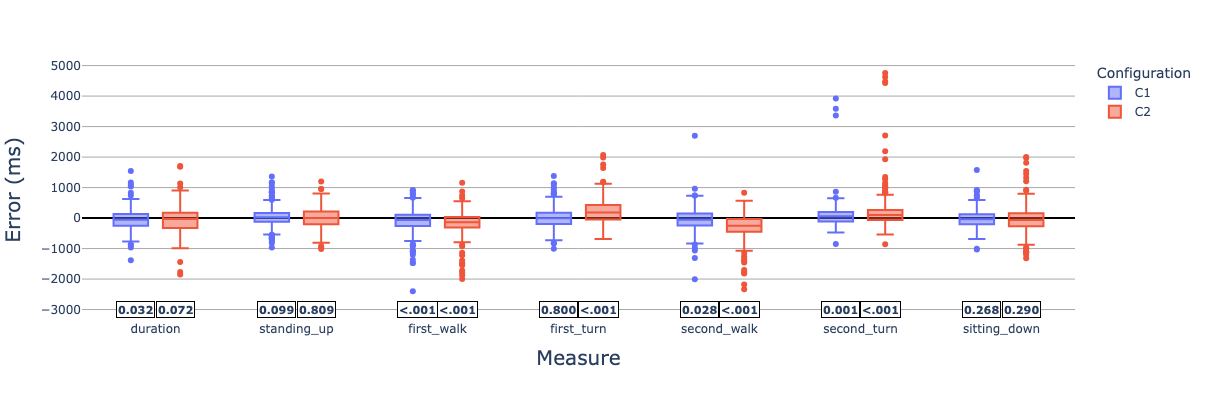

In [17]:
error_distribution_plot = error_distribution(errors_df)
error_distribution_plot

**The above plot corresponds to Figure 6 of the paper**. We can observe:

- For C1, the distribution of errors is not significantly different from 0 for _standing_up_, _first_turn_ and _sitting_down_.
- For C2, the distribution of errors is not significantly different from 0 for _duration_, _standing_up_ and _sitting_down_.
- Errors are significantly different from 0 for _first_walk_, _second_walk_ and _second_turn_ in both configurations.

In [22]:
to_pdf(error_distribution_plot, ERRORS_DISTRIBUTION)

#### Average RMSE by subject and inter-subject RMSE analysis

In [18]:
rmse_df = compute_RMSE_by_subject(errors_df)
rmse_df

duration  standing_up  first_walk  first_turn  second_walk  \
subject system                                                               
s01     C1           222        603.0       794.0       544.0        790.0   
        C2           409        282.0       188.0       157.0        236.0   
s02     C1           422        168.0       246.0       289.0        271.0   
        C2           252        281.0       123.0       303.0        286.0   
s03     C1           410        242.0       600.0       636.0        517.0   
        C2           175        201.0       234.0       368.0        413.0   
s04     C1           456        479.0       298.0       410.0        652.0   
        C2           447        379.0       411.0       462.0        446.0   
s05     C1           438        570.0       571.0       109.0        203.0   
        C2           369        364.0      1199.0      1265.0       1042.0   
s06     C1           295        518.0       472.0       198.0        278.0   
        C2           344        151.0       278.0       344.0        319.0   
s07     C1           366        141.0       157.0       140.0        265.0   
        C2           548        616.0       483.0       285.0        342.0   
s08     C1           241        157.0       277.0       327.0        284.0   
        C2           197        179.0       124.0       344.0        351.0   
s09     C1           390        149.0       137.0       296.0        304.0   
        C2           466        159.0       259.0       419.0        395.0   
s10     C1           218        412.0       570.0       375.0        181.0   
s11     C1           624        445.0       457.0       268.0        311.0   
        C2           538        496.0       377.0       654.0        646.0   
s12     C1           356        264.0       291.0       355.0        240.0   
        C2           640        404.0       315.0       203.0        192.0   
s13     C1           292        214.0       320.0       252.0        298.0   
        C2           506        417.0       279.0       328.0        213.0   
s14     C1           850        355.0       393.0       182.0        259.0   
        C2           513        355.0       192.0       190.0        276.0   
s15     C1           340        336.0       294.0       333.0        448.0   
        C2           340        392.0       205.0       688.0        708.0   
s16     C1           508        481.0       412.0       310.0        392.0   
        C2           561        206.0       241.0       554.0        650.0   
s17     C1           300        291.0       339.0       266.0        366.0   
        C2           773        232.0       216.0       150.0        331.0   
s18     C1           365        408.0       448.0       306.0        298.0   
        C2           236        478.0       344.0       254.0        289.0   
s19     C1           256        327.0       184.0       366.0        388.0   
        C2           438        435.0       953.0       389.0        486.0   
s20     C1           194        559.0      1123.0       561.0        990.0   
        C2           934        590.0      1250.0       526.0       1415.0   
s21     C1           125        277.0       258.0       203.0        321.0   
        C2          1221        426.0       387.0       576.0        799.0   
s22     C1           282        111.0       180.0       403.0        466.0   
        C2           466        221.0       207.0       572.0        614.0   
s23     C1           273        155.0       285.0       187.0        159.0   
        C2           323        122.0       175.0       226.0        174.0   
s24     C1           214        146.0       385.0       830.0        535.0   
        C2           302        572.0       600.0       381.0        334.0   
s25     C1           131        273.0       345.0       138.0        130.0   
s26     C1            67         96.0       285.0       186.0        228.0   
        C2           135        203.0 

In [19]:
rmse_groups_comparison = compare_RMSE_distributions(rmse_df)
rmse_groups_comparison

Measure       M(C1)       M(C2)  \
0      duration  287.000000  389.000000   
1   standing_up  286.766667  336.821429   
2    first_walk  296.000000  268.500000   
3    first_turn  278.500000  356.000000   
4   second_walk  291.000000  338.000000   
5   second_turn  233.000000  217.000000   
6  sitting_down  269.500000  322.500000   

                                                Test  
0                  U=280.5, p-val=0.031, power=0.542  
1  t(55.90)=-1.24, p-val=0.222, power=0.227200895...  
2                  U=460.5, p-val=0.534, power=0.338  
3                  U=285.5, p-val=0.037, power=0.434  
4                  U=326.0, p-val=0.146, power=0.283  
5                  U=410.5, p-val=0.889, power=0.197  
6                   U=280.0, p-val=0.03, power=0.603

**The above table corresponds to Table IV of the paper**. We can observe:

- C1 has significantly better RMSE for _duration_, _first_turn_, and _sitting_down_.
- C1 has better RMSE (not significant) for _standing_up_ and _second_walk_.
- C2 has better RMSE (not significant) for first_walk_ and _second_turn_.

In [20]:
to_csv(rmse_df, RMSE_COMPARISON.format('05_subjects'))
to_csv(rmse_groups_comparison, RMSE_COMPARISON.format('05_comparison'))

#### Bland-Altman analysis

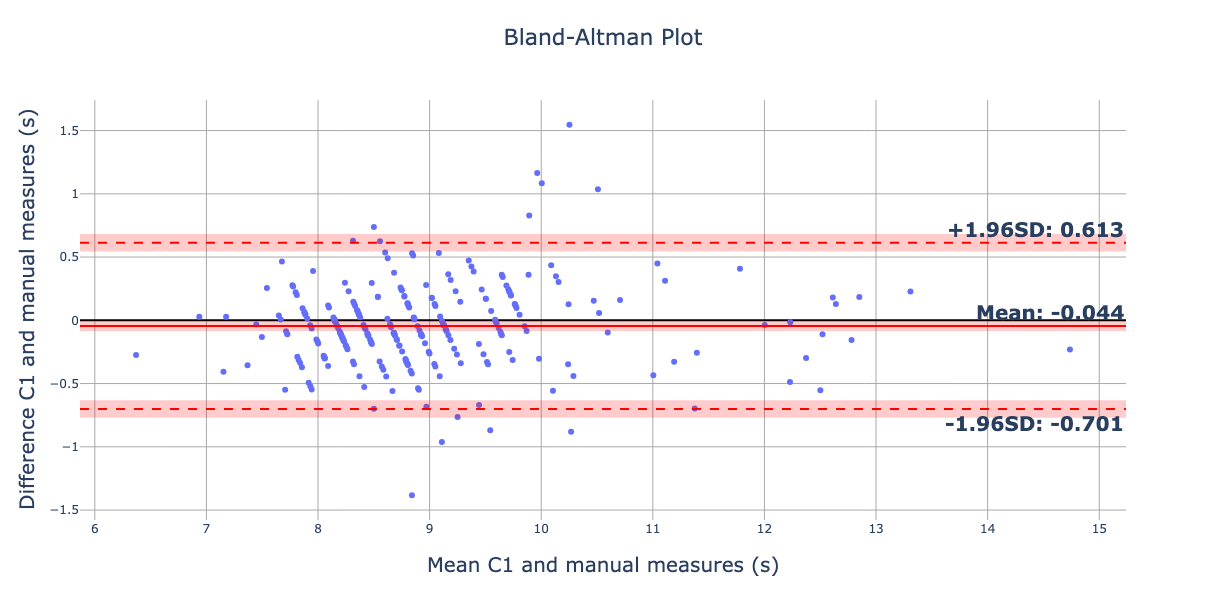

In [21]:
c1_duration_ba = bland_altman_plot(c1_results, man_results, 'C1', ['duration'], with_titles=False)
c1_duration_ba

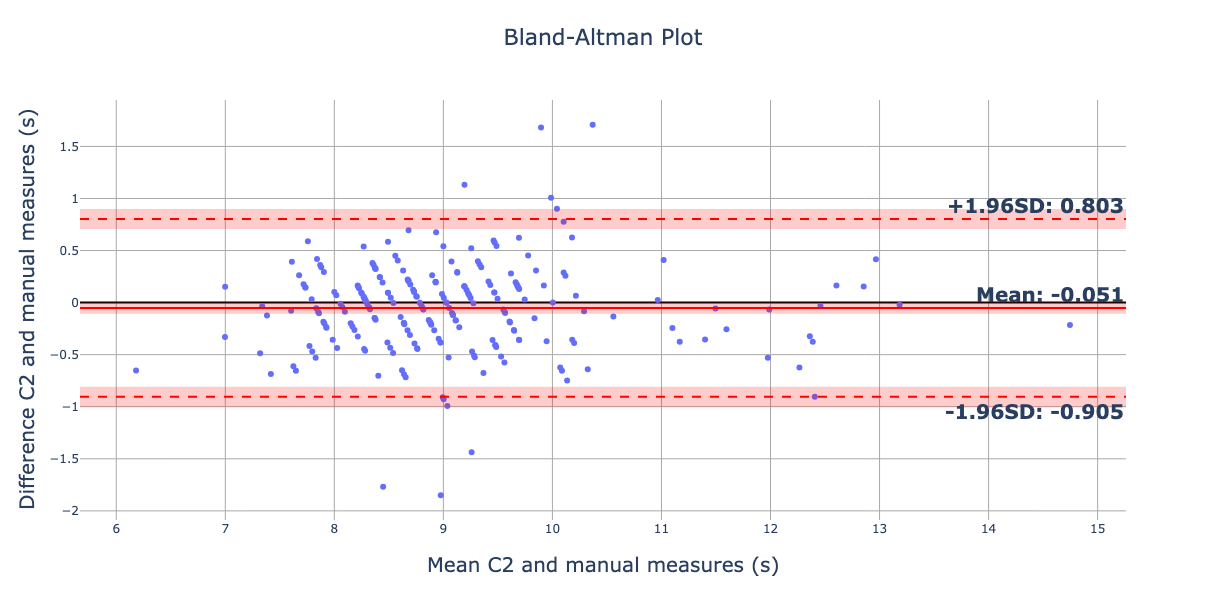

In [22]:
c2_duration_ba = bland_altman_plot(c2_results, man_results, 'C2', ['duration'], with_titles=False)
c2_duration_ba

**The above figures correspond with Figure 7a and 7b of the paper**. We can observe:

- Both configuration present similar results, a bit better in C1.
- Low bias in regards to the reference method. The 5% of measurements exceed an error of 0.7 in C1 and 0.9 in C2.
- Results are satisfactory when compared with literature (around 0.5-1 seconds)

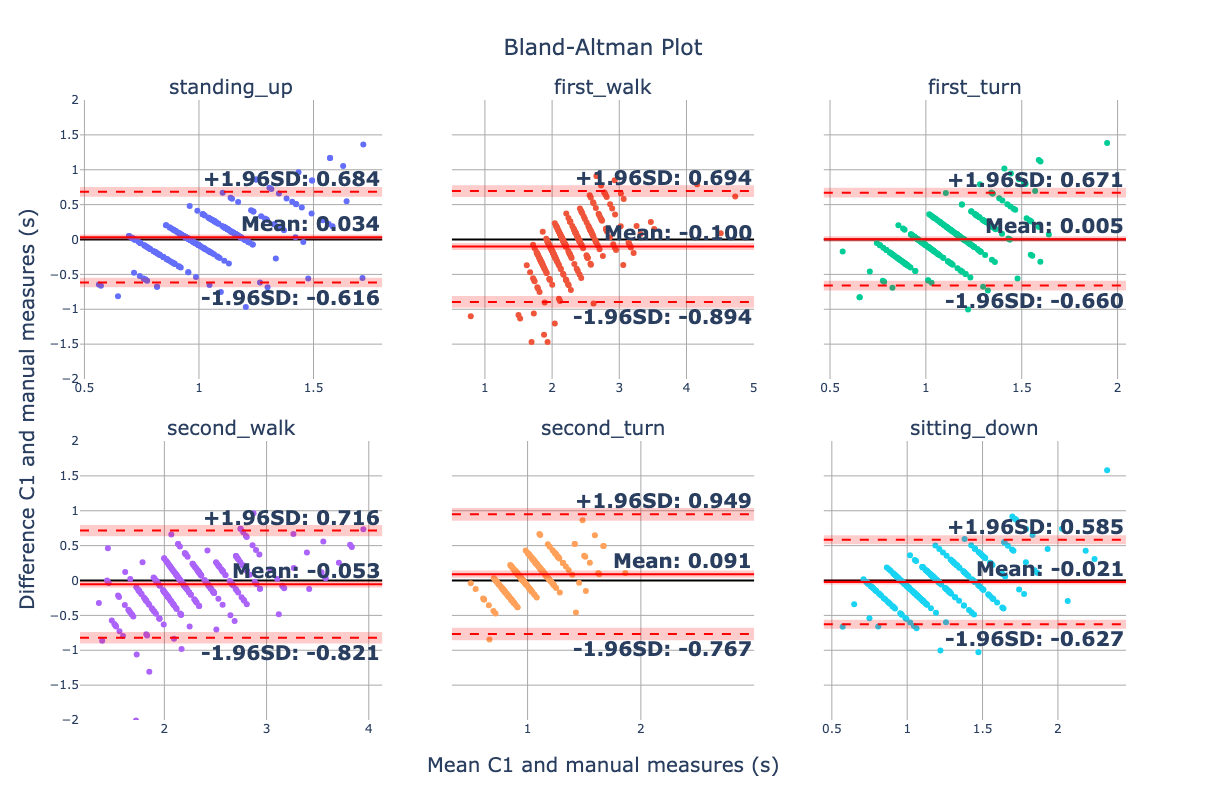

In [23]:
c1_phases_ba = bland_altman_plot(c1_results, man_results, 'C1', PHASES, limit_y_axis_to=[-2, 2])
c1_phases_ba

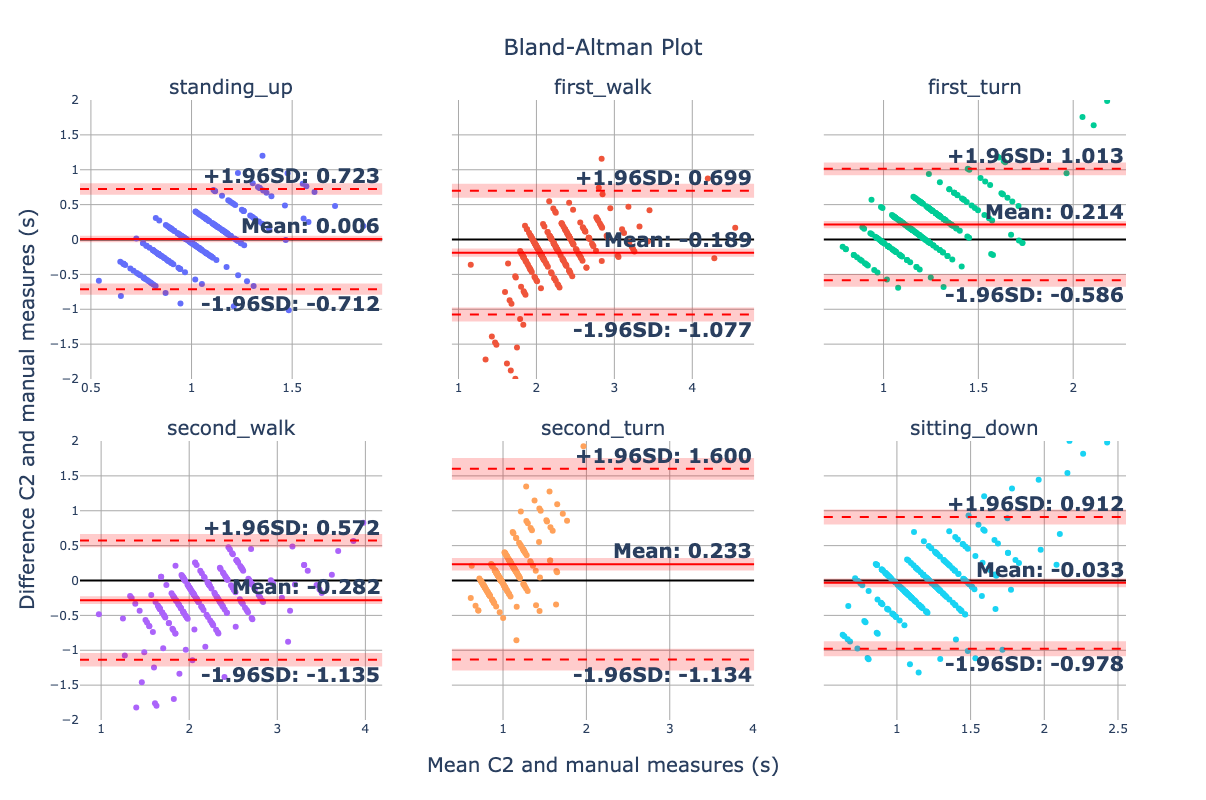

In [24]:
c2_phases_ba = bland_altman_plot(c2_results, man_results, 'C2', PHASES, limit_y_axis_to=[-2, 2])
c2_phases_ba

**The above figures correspond with Figure 8a and 8b of the paper**. We can observe:

- C1 shows better results for all subphases except for _standing_up_.
- Limits of agreement are wide: in C1 are around 0.6 - 0.9 and in C2 they exceed the second.
- Notwithstanding, results are better (C1) and inline (C2) with other results reported in the literature.

In [26]:
to_pdf(c1_duration_ba, BLAND_RESULT.format('06_c1-duration'))
to_pdf(c2_duration_ba, BLAND_RESULT.format('06_c2-duration'))
to_pdf(c1_phases_ba, BLAND_RESULT.format('07_c1-phases'))
to_pdf(c2_phases_ba, BLAND_RESULT.format('07_c2-phases'))

#### ICC analysis

In [27]:
icc_comparison = compute_icc([c1_results, c2_results], man_results, ['C1', 'C2'], icc_type='ICC2')
icc_comparison

ICC             CI  F Test  p-value
phase        system                                       
duration     C1      0.979   [0.96, 0.99]  94.521    0.000
             C2      0.972   [0.94, 0.99]  72.498    0.000
standing_up  C1      0.456    [0.12, 0.7]   2.677    0.005
             C2      0.176  [-0.22, 0.52]   1.414    0.187
first_walk   C1      0.822   [0.63, 0.91]  11.755    0.000
             C2      0.687   [0.32, 0.86]   7.076    0.000
first_turn   C1      0.264  [-0.11, 0.57]   1.694    0.081
             C2      0.026   [-0.19, 0.3]   1.085    0.417
second_walk  C1      0.916   [0.83, 0.96]  24.004    0.000
             C2      0.627    [0.1, 0.84]   6.922    0.000
second_turn  C1      0.540    [0.2, 0.76]   3.987    0.000
             C2      0.107  [-0.19, 0.42]   1.298    0.251
sitting_down C1      0.697   [0.45, 0.84]   5.471    0.000
             C2      0.454     [0.1, 0.7]   2.634    0.007

**The above table correspond to Table V of the paper**. We can observe:

- Both configurations show excellent reliability in the _duration_.
- C1 has:
  - excellent reliability in _second_walk_.
  - good reliability in _first_walk_.
  - moderate reliability _second_turn_ and _sitting_down_.
  - poor reliabiity in _standing_up_ and _first_turn_ (non-significant).
- C2 has:
  - moderate reliability in _first_walk_ and _second_walk_.
  - poor reliabiliry in _standing_up_ (non-significant), _first_turn_ (non-significant), _second_turn_ (non-significant) and _sitting_down_.
- Comparison with literature:
  - _duration_ of both configurations show similar results to the ones reported in the literature .
  - C1 shows similar results in all subphases except for _standing_up_, where we show worse reliability.
  - C2 shows similar results for _first_turn_, _second_turn_ and _sitting_down_, but worse for _standing_up_, _first_walk_ and _second_walk_.

In [28]:
to_csv(icc_comparison, ICC_RESULT)

## Conclusions

- The system can provide reliable measurements for the total duration of the TUG test.
- Measurements of subphases must be considered carefully.
- C1 performed significantly better than C2. This might be due to the pocket diversity and phone orientation in C2 configuration
- Clinical validation on clinically relevant subjects (e.g., limited mobility) is still advisable.